<a href="https://colab.research.google.com/github/Yeshwant-Kasa/Food-Recognition-using-CNN/blob/main/Deep_Learning_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download dansbecker/food-101

100% 9.36G/9.38G [01:21<00:00, 154MB/s]
100% 9.38G/9.38G [01:21<00:00, 123MB/s]


In [ ]:
! unzip food-101.zip

Streaming output truncated to the last 5000 lines.
  inflating: food-101/food-101/images/tacos/1030289.jpg  
  inflating: food-101/food-101/images/tacos/1033196.jpg  
  inflating: food-101/food-101/images/tacos/1036030.jpg  
  inflating: food-101/food-101/images/tacos/1042175.jpg  
  inflating: food-101/food-101/images/tacos/1044043.jpg  
  inflating: food-101/food-101/images/tacos/1058697.jpg  
  inflating: food-101/food-101/images/tacos/1059239.jpg  
  inflating: food-101/food-101/images/tacos/1059326.jpg  
  inflating: food-101/food-101/images/tacos/1066762.jpg  
  inflating: food-101/food-101/images/tacos/1070967.jpg  
  inflating: food-101/food-101/images/tacos/1073468.jpg  
  inflating: food-101/food-101/images/tacos/1075296.jpg  
  inflating: food-101/food-101/images/tacos/1085243.jpg  
  inflating: food-101/food-101/images/tacos/108529.jpg  
  inflating: food-101/food-101/images/tacos/1086014.jpg  
  inflating: food-101/food-101/images/tacos/108945.jpg  
  inflating: food-101/f

In [ ]:
from shutil import copy
from collections import defaultdict
import os


def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

prepare_data('/content/food-101/food-101/meta/train.txt', '/content/food-101/food-101/images', '/content/food-101/food-101/train')
prepare_data('/content/food-101/food-101/meta/test.txt', '/content/food-101/food-101/images', '/content/food-101/food-101/test')


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np

import tensorflow as tf
#print(tf._version_)
print(tf.test.gpu_device_name())

K.clear_session()

n_classes = 101
img_width, img_height = 299, 299
train_data_dir = '/content/food-101/food-101/train'
validation_data_dir = '/content/food-101/food-101/test'
nb_train_samples = 70000
nb_validation_samples = 5000
batch_size = 500

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


mbv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape = (299,299,3))
x = mbv2.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(101,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=mbv2.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class_sept.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained.h5')

/device:GPU:0


FileNotFoundError: ignored

PREDICTIONS BASED ON PICTURES UPLOADED


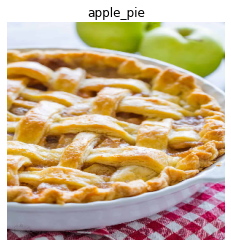

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import load_model


def create_foodlist(path):
    list_ = list()
    for root, dirs, files in os.walk(path, topdown=False):
      for name in dirs:
        list_.append(name)
    return list_    

     
my_model = load_model('model_trained.hdf5', compile = False)
food_list = create_foodlist("/content/food-101/food-101/images") 


def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)    
    food_list.sort()
    pred_value = food_list[0]
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

images = []
images.append('Apple-Pie-2.jpg')
#images.append('caesar.jpg')
#images.append('waffle.jpeg')
#images.append('29744.jpg')
#images.append('pie.jpg')


print("PREDICTIONS BASED ON PICTURES UPLOADED")
predict_class(my_model, images, True)